# Debiasing the Risk Assessment Bias in Criminal Sentencing

Course: CS221 Spring 2019

Team: Amita Patil (amita2@stanford.edu), Jonathan Hollenbeck (jonoh@stanford.edu), Manish Pandit (manish7@stanford.edu)

Project mentor: TODO

## Overview

Recidivism is one of the most fundamental concepts in criminal justice. It refers to a person's relapse into criminal behavior, often after the person receives sanctions or undergoes intervention for a previous crime.

Across the nation, judges, probation and parole officers are increasingly using algorithms to assess a criminal defendant’s likelihood of becoming a recidivist. There are dozens of these risk assessment algorithms in use. Many states have built their own assessments, and several academics have written tools. There are also two leading nationwide tools offered by commercial vendors.

We set out to assess one of the commercial tools made by Northpointe, Inc. to discover the underlying accuracy of their recidivism algorithm and to test whether the algorithm was biased against certain groups.

Our goal is to detect any bias against certain groups exhibited the risk scores from Northpointe's algorithm named COMPAS.  We also investigate techniques and methods to reduce the bias while maintaining the accuracy of the predictions.

We plan to utilize the AI Fairness 360 toolkit from IBM.  The AI Fairness 360 toolkit is an open-source library to help detect and remove bias in machine learning models. The AI Fairness 360 Python package includes a comprehensive set of metrics for datasets and models to test for biases, explanations for these metrics, and algorithms to mitigate bias in datasets and models.

## Dataset

We leverage a dataset that contains more than 10,000 criminal defendants in Broward County, Florida. The dataset contains COMPAS software predicted recidivism rates along with the rate that actually occurred over a two-year period. When most defendants are booked in jail, they respond to a COMPAS questionnaire. Their answers are fed into the COMPAS software to generate several scores including predictions of “Risk of Recidivism” and “Risk of Violent Recidivism.”  We select fields for severity of charge, number of priors, demographics, age, sex, compas scores, and whether each person was accused of a crime within two years.


## References
1. Machine learning bias in risk assessment.
https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing/
2. propublica analysis of compas recidivism algorithm.
https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm/
3. The AI Fairness 360 toolkit is an open-source library to help detect and remove bias in machine learning models.
https://github.com/IBM/AIF360
4. Wikipedia 
https://en.wikipedia.org/wiki/Recidivism

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

We select fields for severity of charge, number of priors, demographics, age, sex, compas scores, and whether each person was accused of a crime within two years.

In [74]:
# datafiles
compas_file = 'compas-scores-two-years.csv'
# violent_file = 'compas-scores-two-years-violent.csv'

In [75]:
compas_df = pd.read_csv(compas_file)
compas_df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [76]:
compas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 53 columns):
id                         7214 non-null int64
name                       7214 non-null object
first                      7214 non-null object
last                       7214 non-null object
compas_screening_date      7214 non-null object
sex                        7214 non-null object
dob                        7214 non-null object
age                        7214 non-null int64
age_cat                    7214 non-null object
race                       7214 non-null object
juv_fel_count              7214 non-null int64
decile_score               7214 non-null int64
juv_misd_count             7214 non-null int64
juv_other_count            7214 non-null int64
priors_count               7214 non-null int64
days_b_screening_arrest    6907 non-null float64
c_jail_in                  6907 non-null object
c_jail_out                 6907 non-null object
c_case_number              7192 non

In [77]:
#y = np.ndarray.astype(compas_df.values[:,-1],int)


There are a number of reasons remove rows because of missing data:

1. If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.
2. We coded the recidivist flag -- is_recid -- to be -1 if we could not find a compas case at all.
3. In a similar vein, ordinary traffic offenses -- those with a c_charge_degree of 'O' -- will not result in Jail time are removed (only two of them).
4. We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.

In [78]:
compas_df = compas_df[np.isfinite(compas_df['days_b_screening_arrest'])]
compas_df = compas_df[compas_df['days_b_screening_arrest'] >= -30.]
compas_df = compas_df[compas_df['days_b_screening_arrest'] <= 30.]
compas_df = compas_df[compas_df['is_recid'] != -1]
compas_df = compas_df[compas_df['c_charge_degree'] != 'O']
compas_df = compas_df[compas_df['score_text'] != 'N/A']

In [83]:
column_list = [
    'id', 'sex', 'age', 'age_cat', 'race',
    'c_charge_degree', 'c_jail_in', 'c_jail_out',
    'juv_fel_count', 'decile_score', 'juv_misd_count', 'juv_other_count',
    'priors_count', 'score_text', 'days_b_screening_arrest',
    'v_decile_score', 'v_score_text', 'two_year_recid'
]

In [84]:
compas_df = compas_df[column_list]

In [85]:
compas_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6172 entries, 0 to 7213
Data columns (total 18 columns):
id                         6172 non-null int64
sex                        6172 non-null object
age                        6172 non-null int64
age_cat                    6172 non-null object
race                       6172 non-null object
c_charge_degree            6172 non-null object
c_jail_in                  6172 non-null object
c_jail_out                 6172 non-null object
juv_fel_count              6172 non-null int64
decile_score               6172 non-null int64
juv_misd_count             6172 non-null int64
juv_other_count            6172 non-null int64
priors_count               6172 non-null int64
score_text                 6172 non-null object
days_b_screening_arrest    6172 non-null float64
v_decile_score             6172 non-null int64
v_score_text               6172 non-null object
two_year_recid             6172 non-null int64
dtypes: float64(1), int64(9), object(

In [86]:
compas_df.head()

,id,sex,age,age_cat,race,c_charge_degree,c_jail_in,c_jail_out,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,score_text,days_b_screening_arrest,v_decile_score,v_score_text,two_year_recid
0,1,Male,69,Greater than 45,Other,F,2013-08-13 06:03:42,2013-08-14 05:41:20,0,1,0,0,0,Low,-1.0,1,Low,0
1,3,Male,34,25 - 45,African-American,F,2013-01-26 03:45:27,2013-02-05 05:36:53,0,3,0,0,0,Low,-1.0,1,Low,1
2,4,Male,24,Less than 25,African-American,F,2013-04-13 04:58:34,2013-04-14 07:02:04,0,4,0,1,4,Low,-1.0,3,Low,1
5,7,Male,44,25 - 45,Other,M,2013-11-30 04:50:18,2013-12-01 12:28:56,0,1,0,0,0,Low,0.0,1,Low,0
6,8,Male,41,25 - 45,Caucasian,F,2014-02-18 05:08:24,2014-02-24 12:18:30,0,6,0,0,14,Medium,-1.0,2,Low,1


In [88]:
compas_df['race'].value_counts()

African-American    3175
Caucasian           2103
Hispanic             509
Other                343
Asian                 31
Native American       11
Name: race, dtype: int64

In [91]:
compas_df['sex'].value_counts()

Male      4997
Female    1175
Name: sex, dtype: int64

In [ ]:
compas_df['sex'].value_counts()

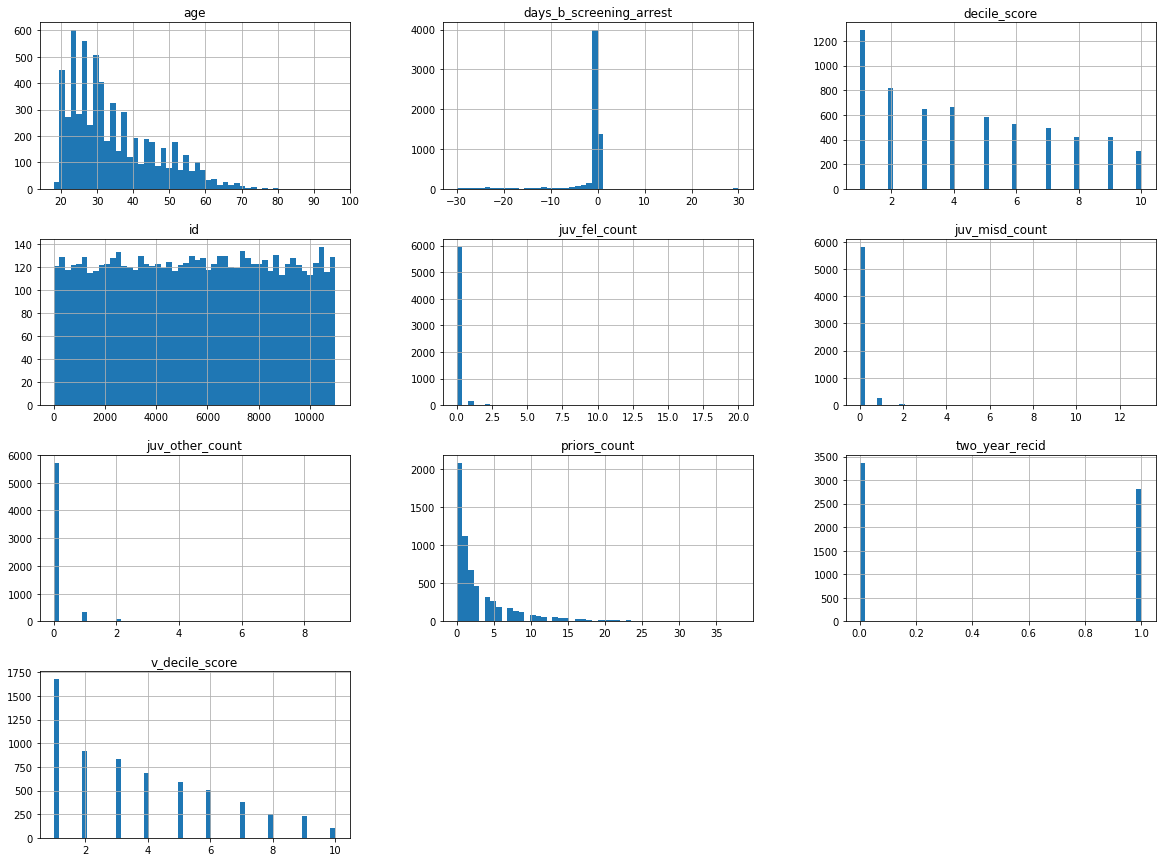

In [90]:
compas_df.hist(bins=50, figsize=(20,15))
plt.show()